## **MA5606 Tópicos Matemáticos en Aprendizaje de Máquinas, Redes Neuronales y Aprendizaje Profundo**

### **Tarea 1: Redes neuronales feedfoward y PINNs**

**Profesores: Claudio Muñoz y Joaquín Fontbona**

**Auxiliares: Javier Maass y Diego Olguín**

**Nombres integrantes: COMPLETAR**

**Instrucciones:**

- **Fecha de entrega:** **26 de abril de 2024, a las 23:59.**

- **Importante:** Si trabaja desde el link de Google Colab (muy recomendable para trabajar con DeepXDE) debe hacer un copia en su Drive antes de trabajar, de lo contrario se podrían no guardar sus códigos.

- Debe entregar un Jupyter Notebook (archivo .ipynb) con sus código en Python. Le pueden ser de mucha utilidad los códigos vistos en la actividad práctica.

- Sus códigos deben estar comentados y ordenados. Además, en formato texto debe colocar todas sus conclusiones y resultados pedidos que deban ser redactados.

- En todos los ejercicios se le pide hacer al menos un gráfico. Los gráficos que realicen deben ser claros, con títulos y nombres en los ejes, junto con leyendas si es que corresponde.

In [1]:
# Librerías

# Numpy y matplotlib, junto con seaborn, para gráficos un poco mejores
import numpy as np
import matplotlib.pyplot as plt

# Puede ser útil para hacer gráficos con barras de colores
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

sns.set_theme()

# PyTorch y módulos que serán necesario
import torch
import torch.nn as nn
import torch.optim as optim

torch.manual_seed(42)

## **Ejercicio 1**

El objetivo de este ejercicio es estudiar la aproximación vía redes neuronales del problema de frontera

$$ y''(x) + \frac{\pi^2}{4} y(x) = 0 $$
$$ y(-1) = y(1) = 0, \, y(0) = 1$$

Para ello utilice redes de 1 capa oculta de ancho $N$, usando $N = \{ 10, 20, 30, 100\}$. Entrene la red con 600 iteraciones del algoritmo ``Adam``.

En cada caso grafique la evolución de la función de pérdida en las iteraciones de entrenamiento, además de la red evaluada en puntos en el intervalo $[-1,1]$ y compare con la solución analítica:

$$ y(x) = \cos \left (\frac{\pi}{2} x \right ) $$

In [2]:
# Creo la clase que define la red neuronal con el codigo del auxiliar:

class NeuralNetwork(nn.Module):
    def __init__(self, dim_input, dim_output, n_layers, layer_width, activation) -> None: 
        super().__init__()
        # Se crean las capas internas
        if n_layers == 0:
            raise ValueError("n_layers debe ser mayor a 0 (o sino sería una red sin llamadas a la función de activación)")
        if type(layer_width) == list:

            assert len(layer_width) == n_layers, "El largo de layer_width, como lista, debe ser igual a n_layers"
            self.first_layer = nn.Linear(dim_input, layer_width[0])
            self.inner_layers = nn.ModuleList([nn.Linear(layer_width[n], layer_width[n+1])
                                           for n in range(n_layers-1)])
            self.last_layer = nn.Linear(layer_width[-1], dim_output)
        else:
            self.first_layer = nn.Linear(dim_input, layer_width)
            self.inner_layers = nn.ModuleList([nn.Linear(layer_width, layer_width)
                                           for n in range(n_layers-1)])
            self.last_layer = nn.Linear(layer_width, dim_output)
        self.activation = activation

    # Función de forward, que dado un input calcula el output de la red
    def forward(self, input):
        input = self.activation(self.first_layer(input))
        for layer in self.inner_layers:
            input = self.activation(layer(input)) # Efecto de activación

        return self.last_layer(input)

In [3]:
# Me robo también el código para las derivadas

def derivative(f, variable):
    return torch.autograd.grad(f.sum(), variable, create_graph=True)[0]

# Finalmente algo que escribo yo:

def ode_difference(x, net):
    y = net(x).unsqueeze(0)
    dy = derivative(y, x)
    ddy = derivative(dy, x)
    return (ddy + (np.pi**2 / 4) * y)

n_layers = 1 # Número de capas
wide = 100 # Ancho


# Dimensiones de entrada y salida, que serán iguales en este caso
dim_input = 1
dim_output = 1

# Red neuronal
net = NeuralNetwork(dim_input, dim_output, n_layers, wide, nn.Tanh())

# Optimizador
optimizer = torch.optim.Adam(net.parameters())

# Pesos de las funciones de pérdida
weights = (1, 1)

# Valores iniciales
x_initial = torch.tensor([[-1.0], [0.0], [1.0]])
y_initial = torch.tensor([[0.], [1.], [0.]])


# Iteraciones de entrenamiento
iters = 600

# Discretización en tiempo
samples_phys = 300

# Iremos guardando la pérdida en cada época
loss_record = []

# Tiempo para evaluar lo que devuelve el residuo de la EDO
x_phys = torch.linspace(-1, 1, samples_phys).reshape((samples_phys, 1)).requires_grad_()

def calc_loss():

    ####
    # Pérdida en la condición inicial
    ####

    # Predicción en el medio
    output_initial = net(x_initial)

    # Objetivo o target, es lo que debería dar, en este caso
    # la condición inicial real
    target_initial = y_initial

    # Cálculo de la perdida en la condición inicial
    loss_initial = nn.MSELoss()(output_initial, target_initial)

    ####
    # Pérdida en la EDO o la física
    ####

    # Evaluación de la red en el residuo de la EDO
    output_phys = ode_difference(x_phys, net)

    # Objetivo, nos debería dar 0 el residuo
    target_phys = torch.zeros_like(output_phys)

    # Cálculo de la perdida en el residuo de la EDO
    loss_phys = nn.MSELoss()(output_phys, target_phys)

    ####
    # Pérdida total
    ####

    # Cálculo de la función de pérdida total
    loss =  weights[0]*loss_phys + weights[1]*loss_initial

    return loss

# Función necesaria para el optimizador
def closure():
    optimizer.zero_grad() # Se actualizan los pesos haciendo gradiente 0
    loss = calc_loss() # Se calcula la función de pérdida
    loss.backward() # Diferenciación automática
    return loss

try:
    for iter in range(1, iters + 1):

        # Guardamos la pérdida calculada
        loss_record.append(calc_loss().item())
        # Paso del optimizador
        optimizer.step(closure)

        # Imprimimos la pérdida en cada iteración, cada ciertas iteraciones
        if iter % 100 == 0:
            print(f'Iterations {iter} || loss: {loss_record[-1]:.6f}')

# Hacer esta sentencia try, except de esta forma hace que
# podamos parar el entrenamiento sin que haya error
except KeyboardInterrupt:
    pass

Iterations 100 || loss: 0.212479
Iterations 200 || loss: 0.104884
Iterations 300 || loss: 0.037660
Iterations 400 || loss: 0.008493
Iterations 500 || loss: 0.001456
Iterations 600 || loss: 0.000442


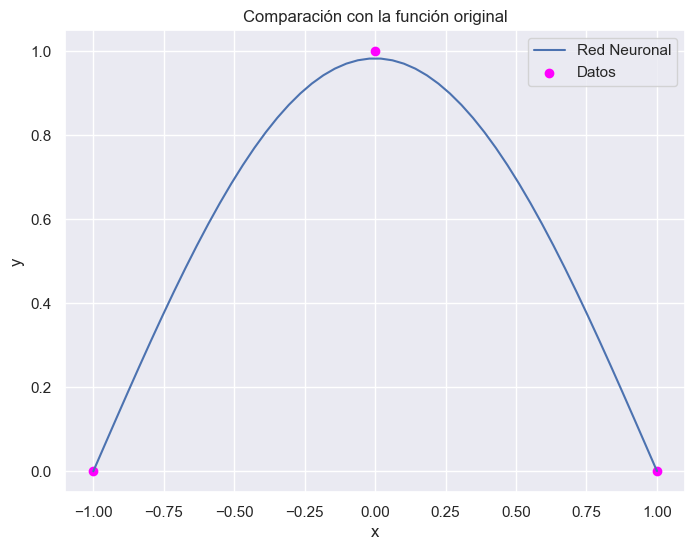

In [4]:
x0, xf = -1, 1
N, dim = 50, 1
size = (N, dim)
# Generamos datos para poder testear el resultado de la red
N_test = 50
X_test = torch.linspace(x0, xf, N_test).reshape((N_test, dim))
y_test = net(X_test).squeeze()
# y_true = y_analitica(X_test).squeeze()

datax = [x_initial[i][0] for i in range(3)]
datay = [y_initial[i][0] for i in range(3)]

fix, ax = plt.subplots(1, 1, figsize=(8, 6))
# Cuando pasamos un tensor a través de una red entrenada
# debemos utilizar detach() para eliminar el grafo que se utiliza
# en la autodiferenciación
ax.plot(X_test, y_test.detach(), label="Red Neuronal")
# ax.scatter(X_test, y_true, label="Verdadero", c="orange")
ax.scatter(datax, datay, c="magenta", label="Datos")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Comparación con la función original")
ax.legend()
plt.show()

## **Ejercicio 2**



Veremos nuevamente el problema de EDP de Helmholtz

$$ -\Delta u - k_0^2 u = f, \quad \Omega = (0,1)^2 $$
$$ u = 0, \quad ∂ Ω $$

Que tiene solución analítica

$$ u(x, y) =  \sin (k_0 x) \sin (k_0 y)$$

Cuando $f(x,y) = k_0^2 \sin (k_0 x) \sin (k_0 y)$. Considere $k_0 = 2 n \pi$ y entrene una red neuronal de 3 capas, 100 neuronas por capa, función de activación seno y 3000 iteraciones del optimizador Adam, que resuelva el problema para $n \in \{ 1, 3, 5 \}$. Grafique la función de pérdida en función de las iteraciones de entrenamiento y el resultado de la red, comparando este con la solución analítica. ¿Qué resultado observa para los distintos $n$ propuestos?

In [5]:
# Instalamos e importamos la librería
try:
    import deepxde as dde
except:
    !pip install deepxde
    import deepxde as dde

# Importamos Tensorflow, que es el backend que utilizaremos
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import seaborn as sns
sns.set_theme()

Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.


### **Ejercicio 3**

Considere el problema de Poisson

$$ -\Delta u = x(1-x) + y(1-y), \quad \Omega = (0,1)^2 $$
$$ u = 0, \quad ∂ Ω $$

Que tiene solución analítica

$$ u(x, y) = \frac{1}{2} x(1-x)y(1-y)$$

Entrene una red neuronal que aproxime la solución al problema, para ello considere una red de 3 capas, 100 neuronas por cada, función de activatión tangente hiperbólica y 500 iteraciones del optimizador Adam. Grafique la función de pérdida en función de las iteraciones de entrenamiento y el resultado de la red, comparando este con la solución analítica del problema.


#### *Solución Ejercicio 3:*


Para poder visualizar el entrenamiento de la red de deepxde como una animación, es necesario implementar un callback como sigue:

In [ ]:
from matplotlib.animation import FuncAnimation

class CallbackAnimación2D(dde.callbacks.Callback):
    def __init__(self,
                filename,
                x_linspace,
                y_linspace,
                sampling_period=1,
                component=0):
        super().__init__()
        arrays = [np.vstack((x_linspace,np.ones(len(x_linspace))*y_linspace[i])) for i in range(len(y_linspace))]
        self.filename = filename
        self.xy = np.hstack(arrays)
        self.X, self.Y = np.meshgrid(x_linspace, y_linspace)
        self.Nx, self.Ny = len(x_linspace), len(y_linspace)
        self.period = sampling_period
        self.component = component
        self.outputs = []
        self.steps_since_last_save = 0

    def on_train_begin(self):
        self.outputs.append(self.model._outputs(False, self.xy.T)[:, self.component])
    
    def on_epoch_end(self):
        self.steps_since_last_save += 1
        if self.steps_since_last_save >= self.period:
            self.steps_since_last_save = 0
            self.on_train_begin()

    def on_train_end(self):
        print("Guardando animación de entrenamiento...")
        
        fname_movie = self.filename
        fig = plt.figure()
        ax = fig.add_subplot(111)
        c1 = ax.contourf(self.X, self.Y, self.outputs[0].reshape((self.Nx, self.Ny)))
        ax.set_xlabel("x")
        ax.set_ylabel("y")

        def update(i):
            c1 = ax.contourf(self.X, self.Y, self.outputs[i].reshape((self.Nx, self.Ny)))
            return c1
        
        anim = FuncAnimation(fig, update, frames=len(self.outputs), blit=False)
        anim.save(fname_movie, writer="ffmpeg", fps=30)


Al igual que para la actividad práctica y el ejercicio 2, utilizaré una transform para forzar el cumplimiento de las condiciones de borde. De hecho, usaré la misma transformación que en el ejercicio 2. Notemos que esto también puede acelerar el entrenamiento, ya que la transformación es muy similar a la función analítica.

In [14]:
# Defino mis funciones.
def poisson(xy, u):
    du_xx = dde.grad.hessian(u, xy, i=0, j=0)
    du_yy = dde.grad.hessian(u, xy, i=1, j=1)
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return -du_xx - du_yy - x*(1 - x) - y*(1 - y)

def transform(xy, u):
    x = xy[:, 0:1]
    y = xy[:, 1:2]
    return u*x*y*(1 - x)*(1 - y)

def u_exact(x, y):
    return 0.5*x*y*(1 - x)*(1 - y)

In [28]:
dim_input = 2
dim_output = 1
its = 500

geom = dde.geometry.Rectangle([0, 0], [1, 1])

bc = []

data = dde.data.PDE(
    geom,
    poisson,
    bc,
    num_domain=400
)

wide, n_layers, activation = 100, 3, "tanh"

net = dde.nn.FNN( # Tengo que entender esto mejor.
    [dim_input] + [wide] * n_layers + [dim_output], activation, "Glorot uniform"
)

net.apply_output_transform(transform)

# Creamos el modelo
model = dde.Model(data, net)

# Compilamos indicando el optimizador
loss_weights = [1, (1, 1)]
model.compile(
    "adam",
    lr=1e-3
)

anim_callback = CallbackAnimación2D("./movie/anim.mp4", np.linspace(0, 1, 100), np.linspace(0, 1, 100), sampling_period=1, component=0)

losshistory, train_state = model.train(iterations=its, display_every=50, callbacks=[anim_callback])


Compiling model...
'compile' took 0.002276 s

Training model...

0         [1.11e-01]    [1.11e-01]    []  
50        [6.16e-05]    [6.16e-05]    []  
100       [2.45e-05]    [2.45e-05]    []  
150       [2.01e-05]    [2.01e-05]    []  
200       [1.69e-05]    [1.69e-05]    []  
250       [1.42e-05]    [1.42e-05]    []  
300       [1.20e-05]    [1.20e-05]    []  
350       [1.01e-05]    [1.01e-05]    []  
400       [8.47e-06]    [8.47e-06]    []  
450       [7.12e-06]    [7.12e-06]    []  
500       [5.97e-06]    [5.97e-06]    []  

Best model at step 500:
  train loss: 5.97e-06
  test loss: 5.97e-06
  test metric: []

'train' took 229.263867 s



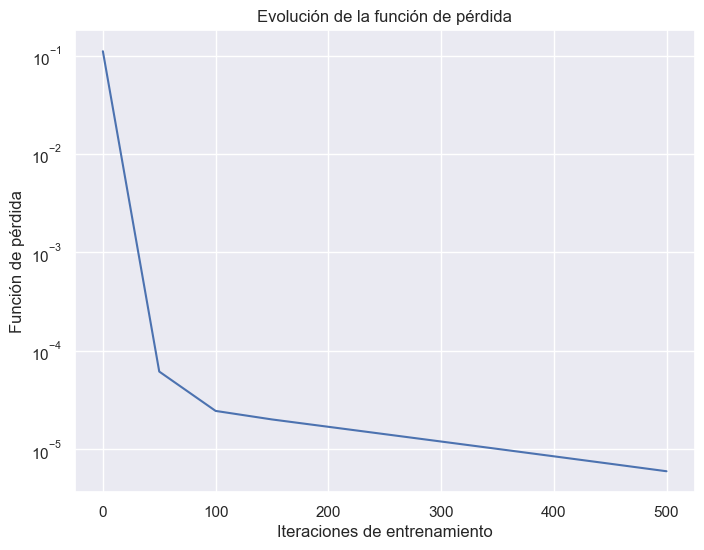

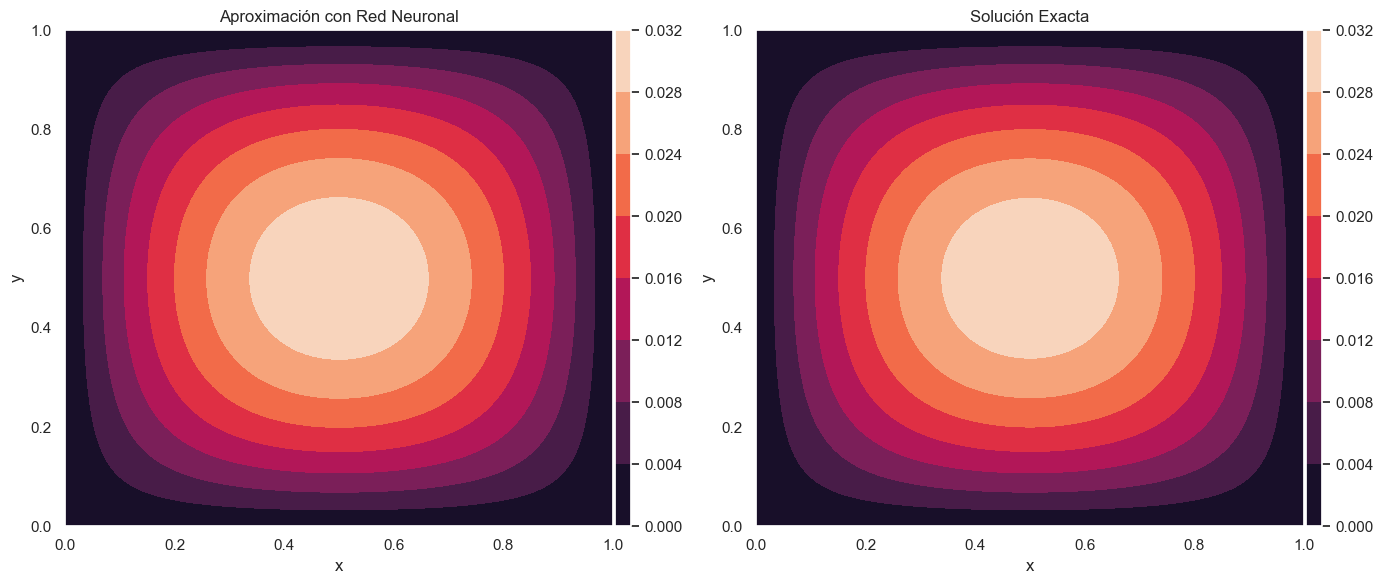

Costo final de la optimización:  [5.96999e-06]
Error en norma L2:  0.0036516849662247015


In [27]:
# Hacemos los gráficos:

plt.figure(figsize=(8, 6))
plt.plot(losshistory.steps, losshistory.loss_train)
plt.yscale("log")
plt.xlabel("Iteraciones de entrenamiento")
plt.ylabel("Función de pérdida")
plt.title("Evolución de la función de pérdida")
plt.show()

from mpl_toolkits.axes_grid1 import make_axes_locatable

x0, xf, y0, yf = 0, 1, 0, 1
Nx, Ny = 100, 100
x, y = np.linspace(x0, xf, Nx), np.linspace(y0, yf, Ny)

arrays = [np.vstack((x,np.ones(Nx)*y[i])) for i in range(Ny)]
X_ = np.hstack(arrays)
u = model.predict(X_.T)

X, Y = np.meshgrid(x, y)

U_exact = u_exact(X, Y)

fig, ax = plt.subplots(1, 2, figsize=(14, 6))

c1 = ax[0].contourf(X, Y, u.reshape((Nx, Ny)))
ax[0].title.set_text("Aproximación con Red Neuronal")
ax[0].set_xlabel("x")
ax[0].set_ylabel("y")

divider = make_axes_locatable(ax[0])
cax = divider.append_axes('right', size='3%', pad=0.02)
fig.colorbar(c1, cax=cax, orientation='vertical')

c2 = ax[1].contourf(X, Y, U_exact)
ax[1].title.set_text("Solución Exacta")
ax[1].set_xlabel("x")
ax[1].set_ylabel("y")

divider = make_axes_locatable(ax[1])
cax = divider.append_axes('right', size='3%', pad=0.02)
fig.colorbar(c2, cax=cax, orientation='vertical')
fig.tight_layout()
plt.show()

print("Costo final de la optimización: ", losshistory.loss_train[-1])
print("Error en norma L2: ", np.linalg.norm(u.reshape((Nx, Ny)) - U_exact, 2))

#### Comentarios:

La aproximación funciona de manera satisfactoria, podemos ver que basta con 100 iteraciones para llegar a un resultado indistinguible visualmente de la función exacta, y la diferencia en norma también indica una gran cercanía de los resultados.

Más iteraciones conllevan una mejora, pero con menor ganancia por cada iteración, como vemos en los cambios de pendiente de la función de pérdida v/s iteraciones. Notamos que el entrenamiento es bastante rápido comparado con las 3000 iteraciones usadas en el ejercicio 2. Sospecho que es debido a la función de transformación que usamos, que es muy similar a la función analítica.